## Binary Classification for Bank Dataset

This project aims to classify whether a client will subscribe to a bank term deposit. The Logistic Regression and XGBoost Models will be used for predictive modeling. The libraries Pandas, Numpy, Matplotlib will be used for data preprocessing and data visualization. XGBoost and Sklearn will be used for Model Selection and Training as well as Performance Metrics which will be evaluated using Accuracy, ROC AUC, Precision, F1-Score and Recall.

In [1]:
# Libraries needed for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from xgboost import XGBClassifier

In [2]:
# Loading In Data and Preprocessing 
train = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv') 
test = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')

le = LabelEncoder()

for col in train.select_dtypes(include='object').columns:
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])

print(train.columns)

x = train[train.columns[1:-1]].to_numpy()
y = train[train.columns[-1]].to_numpy().ravel() # To create 1-D array

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')


                  id            age            job        marital  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      40.926395       4.321157       1.160569   
std    216506.495284      10.098829       3.256919       0.577240   
min         0.000000      18.000000       0.000000       0.000000   
25%    187499.750000      33.000000       1.000000       1.000000   
50%    374999.500000      39.000000       4.000000       1.000000   
75%    562499.250000      48.000000       7.000000       2.000000   
max    749999.000000      95.000000      11.000000       2.000000   

           education        default        balance        housing  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean        1.227461       0.017132    1204.067397       0.548384   
std         0.705607       0.129763    2836.096759       0.497654   
min         0.000000       0.000000   -8019.000000       0.000000   
25%         1.000000       0.0000

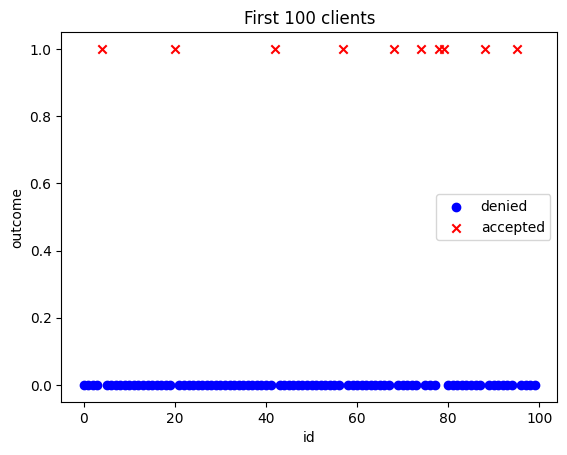

In [3]:
# Basic Data Information and Exploratory Data Analysis
print(train.describe())
print("\n----------\n")
print(train.info())
print("\n----------\n")
print(x.shape, y.shape)

# Scatter Plot of whether first 100 clients subscribed to a term deposit
sample = train[:100]

class0 = sample[sample['y'] == 0]
class1 = sample[sample['y'] == 1]

plt.scatter(class0['id'], class0['y'], marker='o', color='blue', label='denied')
plt.scatter(class1['id'], class1['y'], marker='x', color='red', label='accepted')

plt.xlabel('id')
plt.ylabel('outcome')
plt.title('First 100 clients')
plt.legend()
plt.show()

## Logistic Regression

In [4]:
# Implementing the model using Sklearn
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 16)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model = LogisticRegression(solver='saga',max_iter = 1000,tol=1e-4,n_jobs=-1)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# Performance Metrics 
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.97      0.94    164927
           1       0.60      0.31      0.41     22573

    accuracy                           0.89    187500
   macro avg       0.76      0.64      0.68    187500
weighted avg       0.87      0.89      0.88    187500



## XGBoost

In [5]:
# Implementing the model using Sklearn and XGBoost alongside RandomizedSearchCV for hyperparameter tuning
xgb = XGBClassifier(random_state = 42)

param_grid = {
    'n_estimators': [25,50,100],
    'max_depth': [4,8,12],
    'learning_rate': [0.01,0.1,0.2],
}
    
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1,   ## To use all CPU Cores
)

random_search.fit(x_train, y_train)
best_model = random_search.best_estimator_  # Chooses the model with highest accuracy

xgb_y_pred = best_model.predict(x_test)

# Performance Metrics
print(classification_report(y_test,xgb_y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

           0       0.96      0.97      0.96    164927
           1       0.76      0.67      0.72     22573

    accuracy                           0.94    187500
   macro avg       0.86      0.82      0.84    187500
weighted avg       0.93      0.94      0.93    187500



# Model Evaluation and Visualization

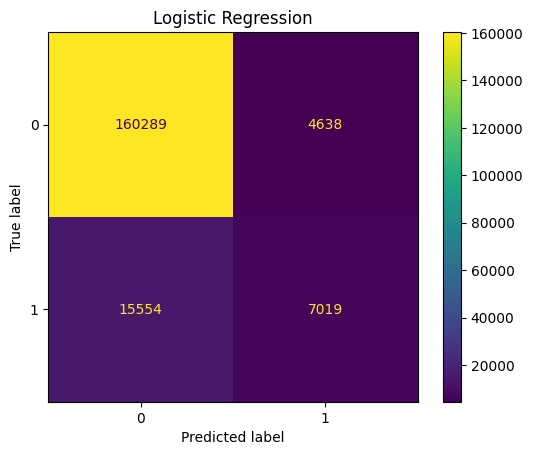

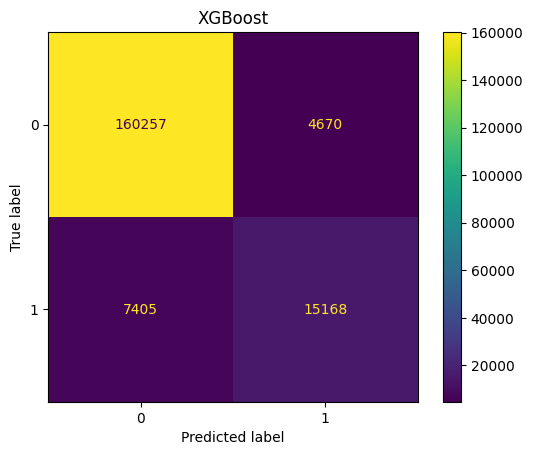

Index(['id', 'y'], dtype='object')


In [6]:
# Confusion Matrices
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic Regression")
plt.show()

cm = confusion_matrix(y_test, xgb_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("XGBoost")
plt.show()

# Writing Probabilities into Submission File
test_array = test[test.columns[1:]].to_numpy()
z = best_model.predict_proba(test_array)[:,1]
df = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')
print(df.columns)
df['y'] = z
df.to_csv('submission.csv',index=False) 